<a href="https://colab.research.google.com/github/IsharaSilva/Prediction-Recommedation-system-for-Potato-Cultivation/blob/main/Detect_the_types_of_viruses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/IsharaSilva/Prediction-Recommedation-system-for-Potato-Cultivation.git

Cloning into 'Prediction-Recommedation-system-for-Potato-Cultivation'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 178 (delta 44), reused 0 (delta 0), pack-reused 113
Receiving objects: 100% (178/178), 45.08 MiB | 24.72 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pickle

data_path = '/content/drive/MyDrive/Data/M_Data'
classes = {'PSTV foliar symptoms': 0, 'Rugose mosaic symptom': 1}

In [7]:
# Read the data file names and corresponding labels
data = []
labels = []
for class_name, label in classes.items():
    class_path = os.path.join(data_path, class_name)
    file_names = os.listdir(class_path)
    for file_name in file_names:
        file_path = os.path.join(class_path, file_name)
        data.append(file_path)
        labels.append(label)

In [8]:
 # Split the data into training, validation, and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)


In [9]:
# Load and preprocess the images
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    
    # Background removal using thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    image[thresholded == 0] = [0, 0, 0]  # Set background pixels to black
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (128, 128))
    return image

train_images = [preprocess_image(image_path) for image_path in train_data]
val_images = [preprocess_image(image_path) for image_path in val_data]
test_images = [preprocess_image(image_path) for image_path in test_data]

In [10]:
# Print the size of each set
print('Training set size:', len(train_data))
print('Validation set size:', len(val_data))
print('Testing set size:', len(test_data))

Training set size: 448
Validation set size: 112
Testing set size: 140


In [11]:
# Convert the images and labels to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [12]:
# FEATURE EXTRACTOR function
def feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):
        df = pd.DataFrame()
        img = x_train[image]
        
        # FEATURE 1 - Pixel values
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values
        
        # FEATURE 2 - Gabor filter responses
        num = 1
        kernels = []
        for theta in range(2):
            theta = theta / 4. * np.pi
            for sigma in (1, 3):
                lamda = np.pi / 4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)
                kernel = cv2.getGaborKernel((9, 9), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                kernels.append(kernel)
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img
                num += 1
                
        # Append features from the current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

# Extract features from training images
image_features = feature_extractor(train_images)

<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [13]:
# Reshape for SVM training
n_samples = train_images.shape[0]
image_features = np.array(image_features)
image_features = np.reshape(image_features, (n_samples, -1))

In [16]:
# Define the classifier
SVM_model = SVC(kernel='rbf', random_state=42)

In [20]:
# Fit the model on training data
SVM_model.fit(image_features, train_labels)

# Save the trained model
with open('/content/drive/MyDrive/Data/SVM_model.pkl', 'wb') as file:
    pickle.dump(SVM_model, file)

# Extract features from test data and reshape
test_features = feature_extractor(test_images)
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_images.shape[0], -1))

# Predict on test data
test_predictions = SVM_model.predict(test_features)

# Convert labels back to original class names
le = LabelEncoder()
le.fit(labels)
test_predictions = le.inverse_transform(test_predictions)



<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)
<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [21]:
# Print overall accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9357142857142857


In [22]:
# Print precision, recall, and F1 score
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9418766627806174
Recall: 0.9357142857142857
F1 Score: 0.9364099517945671


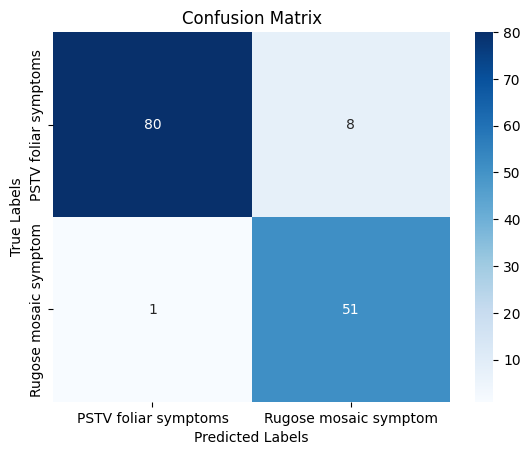

In [23]:
# Print confusion matrix
confusion = confusion_matrix(test_labels, test_predictions)
class_names = list(classes.keys())
fig, ax = plt.subplots()
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


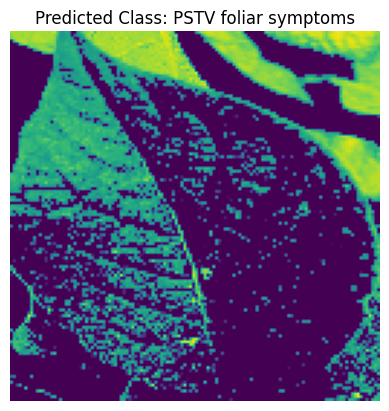

<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


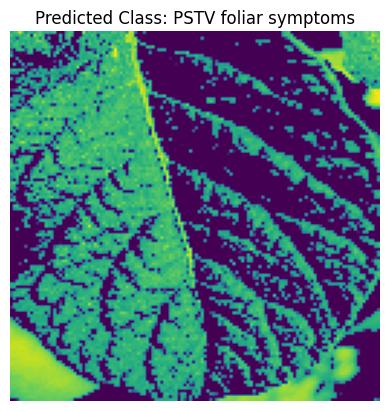

<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


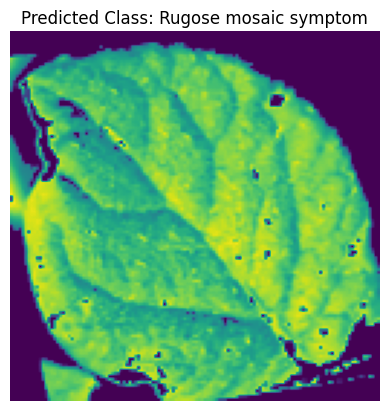

<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


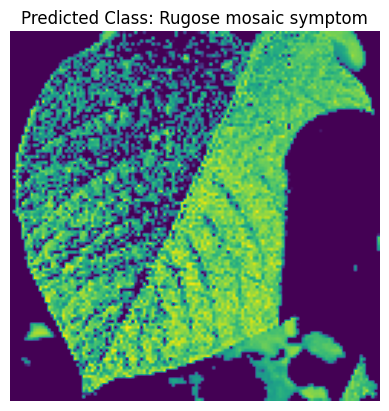

<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


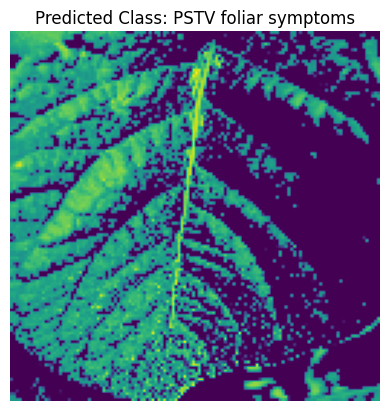

<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


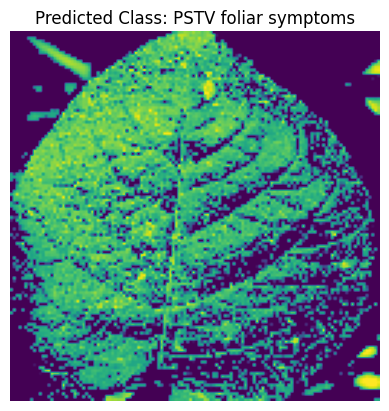

<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


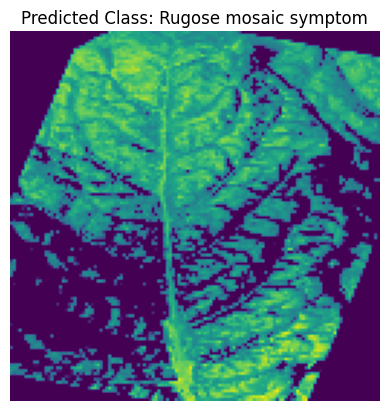

<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


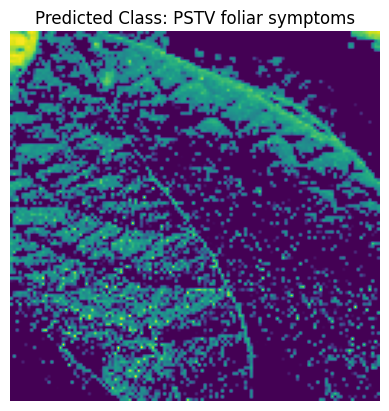

<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


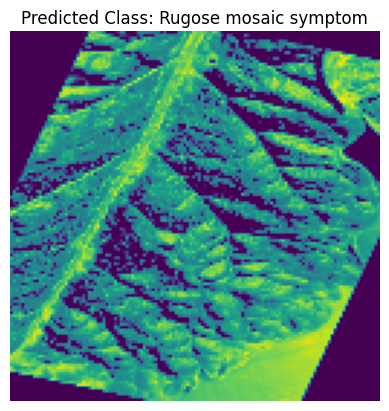

<ipython-input-12-e91f85abbbac>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_dataset = image_dataset.append(df)


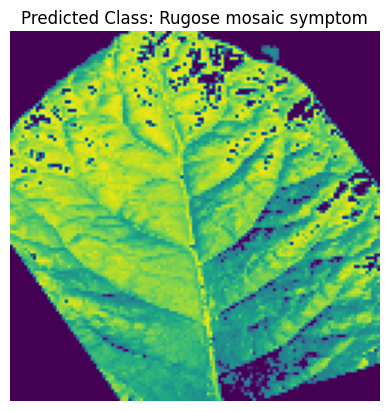

In [24]:
# Import the necessary libraries
import random

# Select 10 random indices from the test dataset
random_indices = random.sample(range(len(test_data)), 10)

# Iterate over the random indices and make predictions
for index in random_indices:
    # Get the image path and preprocess the image
    image_path = test_data[index]
    preprocessed_image = preprocess_image(image_path)
    
    # Extract features and reshape for prediction
    input_img = np.expand_dims(preprocessed_image, axis=0)
    input_img_features = feature_extractor(input_img)
    input_img_features = np.expand_dims(input_img_features, axis=0)
    input_img_for_SVM = np.reshape(input_img_features, (input_img.shape[0], -1))
    
    # Make the prediction
    img_prediction = SVM_model.predict(input_img_for_SVM)
    img_prediction = le.inverse_transform(img_prediction)
    
    # Convert the class label to class name
    prediction_class_name = class_names[img_prediction[0]]
    
    # Display the image and predicted class
    plt.imshow(preprocessed_image, cmap='viridis')
    plt.axis('off')
    plt.title("Predicted Class: " + prediction_class_name)
    plt.show()